In [12]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("../data/sentiment_analysis_dataset.csv")

# Vista rápida
print("Columnas originales:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)
df.head()


Columnas originales: ['user', 'text', 'date', 'emotion', 'sentiment']
Tamaño del dataset: (2590, 5)


,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [13]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Descargar stopwords (solo primera vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# 🔹 Función de limpieza
def clean_text(text):
    text = text.lower()  # minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URLs
    text = re.sub(r"@\w+", "", text)  # menciones
    text = re.sub(r"#\w+", "", text)  # hashtags
    text = re.sub(r"[^\w\s]", "", text)  # puntuación
    text = " ".join([word for word in text.split() if word not in stop_words])  # stopwords
    return text.strip()

# 🔹 Aplicar limpieza
df["clean_text"] = df["text"].astype(str).apply(clean_text)
df[["text", "clean_text"]].head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,termine bien abrumado después de hoy,termine bien abrumado después hoy
1,me siento abrumado,siento abrumado
2,Me siento un poco abrumado por la cantidad de ...,siento abrumado cantidad cosas quiero dibujar ...
3,Salvador la única persona que no la ha abrumad...,salvador única persona abrumado versiones
4,Denme un helado o algo que ando full abrumado.,denme helado ando full abrumado
5,"Estoy abrumado de airdrops , de youtube y de t...",abrumado airdrops youtube imposible gestionarl...
6,"#MicroCuento: A veces, sin motivo aparente, o,...",veces motivo aparente bien razones quizás fúti...
7,"Oh, las vacaciones. Tesoros inciertos, venider...",oh vacaciones tesoros inciertos venideros prec...
8,me siento muy abrumado,siento abrumado
9,Consejo que nadie pidió: Si un día te siente...,consejo nadie pidió si día sientes abrumado tr...


In [14]:
from collections import Counter
import numpy as np

texts = df["clean_text"].astype(str).tolist()
sentences = [t.split() for t in texts]

min_freq = 3
counter = Counter([w for s in sentences for w in s])

# índices especiales
PAD, UNK, BOS, EOS = "<PAD>", "<UNK>", "<BOS>", "<EOS>"

vocab = {PAD:0, UNK:1, BOS:2, EOS:3}
for w, c in counter.items():
    if c >= min_freq and w not in vocab:
        vocab[w] = len(vocab)

inv_vocab = {i:w for w,i in vocab.items()}
vocab_size = len(vocab)

def encode_sentence(text):
    tokens = text.split()
    ids = [vocab.get(BOS)] + [vocab.get(w, vocab[UNK]) for w in tokens] + [vocab.get(EOS)]
    return ids

encoded = [encode_sentence(t) for t in texts]



In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

max_len = 40  # por ejemplo

def pad(seq, max_len, pad_id=0):
    return seq[:max_len] + [pad_id] * max(0, max_len - len(seq))

class LMDataset(Dataset):
    def __init__(self, encoded_sentences, max_len=40):
        self.data = []
        for s in encoded_sentences:
            if len(s) < 3:  # muy corto
                continue
            inp = pad(s[:-1], max_len)
            tgt = pad(s[1:], max_len)
            self.data.append((inp, tgt))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        inp, tgt = self.data[idx]
        return torch.tensor(inp), torch.tensor(tgt)

# split train / val
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(encoded, test_size=0.2, random_state=42)

train_dataset = LMDataset(train_ids, max_len=max_len)
val_dataset   = LMDataset(val_ids, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)


# RNN Básica

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.RNN(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity="tanh"
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        emb = self.embedding(x)      # (batch, seq_len, emb_dim)
        out, hidden = self.rnn(emb, hidden)  # (batch, seq_len, hidden_dim)
        out = self.dropout(out)
        logits = self.fc(out)        # (batch, seq_len, vocab_size)
        return logits, hidden


## LSTM

In [17]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits, hidden


In [18]:
import math
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_idx = vocab[PAD]   # normalmente 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_tokens, total_correct = 0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        logits, _ = model(x)  # (batch, seq, vocab)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # ignoramos padding para las métricas
            mask = (y != pad_idx)
            preds = logits.argmax(-1)
            total_correct += (preds[mask] == y[mask]).sum().item()
            total_tokens += mask.sum().item()
            total_loss += loss.item() * mask.sum().item()
    
    avg_loss = total_loss / total_tokens
    acc = total_correct / total_tokens
    ppl = math.exp(avg_loss)
    return avg_loss, acc, ppl


def evaluate(model, loader):
    model.eval()
    total_loss, total_tokens, total_correct = 0, 0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            
            mask = (y != pad_idx)
            preds = logits.argmax(-1)
            total_correct += (preds[mask] == y[mask]).sum().item()
            total_tokens += mask.sum().item()
            total_loss += loss.item() * mask.sum().item()
    
    avg_loss = total_loss / total_tokens
    acc = total_correct / total_tokens
    ppl = math.exp(avg_loss)
    return avg_loss, acc, ppl


def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = {
        "train_loss": [], "train_acc": [], "train_ppl": [],
        "val_loss": [],   "val_acc": [],   "val_ppl": []
    }
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, train_ppl = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc, val_ppl       = evaluate(model, val_loader)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_ppl"].append(train_ppl)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_ppl"].append(val_ppl)
        
        print(
            f"Época {epoch:02d} | "
            f"train loss: {train_loss:.3f} | train ppl: {train_ppl:.2f} | train acc: {train_acc*100:.1f}% || "
            f"val loss: {val_loss:.3f} | val ppl: {val_ppl:.2f} | val acc: {val_acc*100:.1f}%"
        )
    
    return model, history


In [25]:
# Entrenamos la RNN
model_rnn = RNNLanguageModel(vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.3)
model_rnn, history_rnn = train_model(model_rnn, train_loader, val_loader, num_epochs=200, lr=1e-3)

# Entrenamos la LSTM
model_lstm = LSTMLanguageModel(vocab_size, emb_dim=128, hidden_dim=256, num_layers=1, dropout=0.3)
model_lstm, history_lstm = train_model(model_lstm, train_loader, val_loader, num_epochs=200, lr=1e-3)


Época 01 | train loss: 6.197 | train ppl: 491.48 | train acc: 23.4% || val loss: 5.634 | val ppl: 279.70 | val acc: 28.8%
Época 02 | train loss: 5.626 | train ppl: 277.57 | train acc: 27.6% || val loss: 5.558 | val ppl: 259.28 | val acc: 28.8%
Época 03 | train loss: 5.539 | train ppl: 254.53 | train acc: 27.7% || val loss: 5.513 | val ppl: 247.93 | val acc: 28.8%
Época 04 | train loss: 5.445 | train ppl: 231.52 | train acc: 27.7% || val loss: 5.475 | val ppl: 238.55 | val acc: 28.9%
Época 05 | train loss: 5.342 | train ppl: 209.02 | train acc: 27.8% || val loss: 5.428 | val ppl: 227.63 | val acc: 29.1%
Época 06 | train loss: 5.224 | train ppl: 185.70 | train acc: 28.1% || val loss: 5.391 | val ppl: 219.34 | val acc: 29.2%
Época 07 | train loss: 5.099 | train ppl: 163.88 | train acc: 28.7% || val loss: 5.339 | val ppl: 208.24 | val acc: 29.6%
Época 08 | train loss: 4.961 | train ppl: 142.75 | train acc: 29.4% || val loss: 5.292 | val ppl: 198.79 | val acc: 30.1%
Época 09 | train loss: 4

In [26]:
import pandas as pd

resultados = pd.DataFrame({
    "modelo": ["RNN", "LSTM"],
    "val_loss": [history_rnn["val_loss"][-1], history_lstm["val_loss"][-1]],
    "val_ppl":  [history_rnn["val_ppl"][-1],  history_lstm["val_ppl"][-1]],
    "val_acc":  [history_rnn["val_acc"][-1],  history_lstm["val_acc"][-1]],
})
resultados


,modelo,val_loss,val_ppl,val_acc
0,RNN,7.192487,1329.404988,0.391008
1,LSTM,7.580003,1958.635483,0.380866


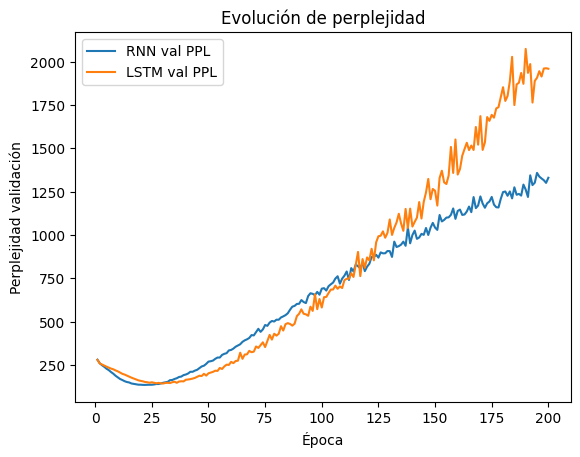

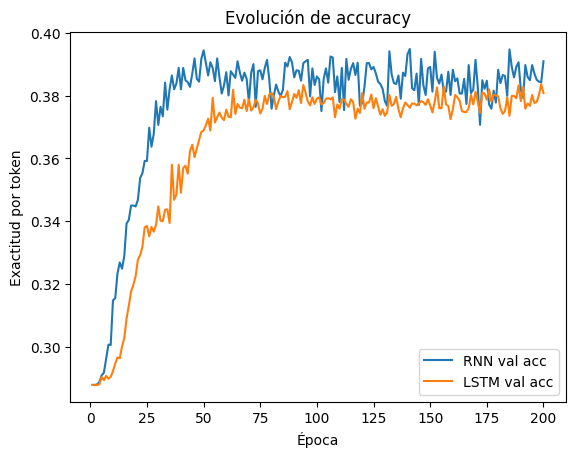

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_rnn["val_ppl"]) + 1)

plt.figure()
plt.plot(epochs, history_rnn["val_ppl"], label="RNN val PPL")
plt.plot(epochs, history_lstm["val_ppl"], label="LSTM val PPL")
plt.xlabel("Época")
plt.ylabel("Perplejidad validación")
plt.legend()
plt.title("Evolución de perplejidad")
plt.show()

plt.figure()
plt.plot(epochs, history_rnn["val_acc"], label="RNN val acc")
plt.plot(epochs, history_lstm["val_acc"], label="LSTM val acc")
plt.xlabel("Época")
plt.ylabel("Exactitud por token")
plt.legend()
plt.title("Evolución de accuracy")
plt.show()


In [30]:
import torch

def generate_text(model, start_text, max_new_tokens=25, temperature=1.0):
    model.eval()
    
    # codificamos solo el texto inicial, sin el EOS final
    ids = encode_sentence(start_text)
    ids = ids[:-1]  # quitamos EOS para que el modelo lo pueda predecir
    
    input_ids = torch.tensor(ids, device=device).unsqueeze(0)  # (1, seq_len)
    hidden = None
    
    generated = ids[:]  # copiamos tokens iniciales
    
    for _ in range(max_new_tokens):
        logits, hidden = model(input_ids, hidden)   # (1, seq_len, vocab)
        logits = logits[:, -1, :] / temperature    # último paso
        
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        
        generated.append(next_id)
        if next_id == vocab[EOS]:
            break
        
        input_ids = torch.tensor([[next_id]], device=device)
    
    # decodificar ignorando PAD/BOS/EOS
    palabras = []
    for idx in generated:
        token = inv_vocab.get(idx, UNK)
        if token in [PAD, BOS, EOS]:
            continue
        palabras.append(token)
    return " ".join(palabras)


for modelo, nombre in [(model_rnn, "RNN"), (model_lstm, "LSTM")]:
    print(f"\n=== Generación con {nombre} ===")
    print(generate_text(modelo, "hoy me siento", max_new_tokens=20, temperature=1.0))



=== Generación con RNN ===
hoy <UNK> siento <UNK> <UNK> amor pregunta siguiente <UNK> niego sentirme <UNK> saben corazón

=== Generación con LSTM ===
hoy <UNK> siento <UNK> <UNK> calle verdad <UNK> <UNK> miedo <UNK> pasado semana <UNK> control <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> compras mayores


# Seq2Seq (emilio)

In [23]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
    
    def forward(self, src):
        emb = self.embedding(src)
        outputs, (h, c) = self.lstm(emb)
        # outputs: (batch, src_len, hidden_dim)
        return outputs, (h, c)


class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input_step, hidden):
        # input_step: (batch, 1)
        emb = self.embedding(input_step)
        output, hidden = self.lstm(emb, hidden)   # output: (batch,1,hidden)
        logits = self.fc(output)                  # (batch,1,vocab)
        return logits, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.shape
        vocab_size = self.decoder.fc.out_features
        
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        
        enc_outputs, hidden = self.encoder(src)
        
        # primer token de entrada al decoder = BOS
        input_step = tgt[:, 0].unsqueeze(1)  # (batch,1)
        
        for t in range(1, tgt_len):
            logits, hidden = self.decoder(input_step, hidden)
            outputs[:, t:t+1, :] = logits
            top1 = logits.argmax(-1)  # (batch,1)
            use_teacher = torch.rand(1).item() < teacher_forcing_ratio
            input_step = tgt[:, t:t+1] if use_teacher else top1
        return outputs


In [24]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.score = nn.Linear(hidden_dim, hidden_dim, bias=False)
    
    def forward(self, dec_hidden, enc_outputs, mask=None):
        # dec_hidden: (batch, hidden_dim)  estado actual del decoder
        # enc_outputs: (batch, src_len, hidden_dim)
        # 1) proyectar hidden y hacer producto punto con cada estado del encoder
        score_proj = self.score(dec_hidden).unsqueeze(2)  # (batch, hidden_dim,1)
        attn_scores = torch.bmm(enc_outputs, score_proj).squeeze(2)  # (batch, src_len)
        
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, src_len)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs)  # (batch,1,hidden_dim)
        return context, attn_weights


class AttnDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.attn = LuongAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)  # hidden + context
    
    def forward(self, input_step, hidden, enc_outputs, mask=None):
        emb = self.embedding(input_step)
        output, hidden = self.lstm(emb, hidden)  # output: (batch,1,hidden)
        dec_hidden = output.squeeze(1)          # (batch,hidden)
        
        context, attn_weights = self.attn(dec_hidden, enc_outputs, mask)
        concat = torch.cat([output, context], dim=-1)  # (batch,1,2*hidden)
        logits = self.fc(concat)                       # (batch,1,vocab)
        return logits, hidden, attn_weights
